### libs

In [1]:
import matplotlib.pyplot as plt
# from matplotlib import gridspec
from matplotlib.pyplot import cm

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import integrate
from csaps import csaps

from pathlib import Path

### functions & initialization

In [2]:
def normalize_cluster(cluster):
    cluster['x'] *= R_norm
    cluster['y'] *= R_norm
    cluster['z'] *= R_norm

    cluster['vx'] *= V_norm
    cluster['vy'] *= V_norm
    cluster['vz'] *= V_norm

    cluster['M'] *= M_norm
    cluster['M_ini'] *= M_norm
    
    return cluster

In [3]:
def spherical_coords(cluster_obs, density_cs, file):
    xc, yc, zc = density_cs.iloc[snapshot, 1:4]
    vxc, vyc, vzc = density_cs.iloc[snapshot, 4:7]
    
    r = np.sqrt((cluster_obs['x'] - xc) ** 2 + (cluster_obs['y'] - yc) ** 2 + (cluster_obs['z'] - zc) ** 2)
    phi = np.arctan2((cluster_obs['y'] - yc), (cluster_obs['x'] - xc))
    theta = np.arccos((cluster_obs['z'] - zc)/r)
    #np.arctan2(np.sqrt((cluster_obs['x'] - xc) ** 2 + (cluster_obs['y'] - yc) ** 2), (cluster_obs['z'] - zc))
    vr = (cluster_obs['vx'] - vxc) * np.cos(phi) * np.sin(theta) + \
         (cluster_obs['vy'] - vyc) * np.sin(phi) * np.sin(theta) + \
         (cluster_obs['vz'] - vzc) * np.cos(theta)
    return r, vr

In [4]:
# xc, yc, zc = density_cs.iloc[snapshot, 1:4]
# vxc, vyc, vzc = density_cs.iloc[snapshot, 4:7]

# r = np.sqrt((cluster_obs['x'] - xc) ** 2 + (cluster_obs['y'] - yc) ** 2 + (cluster_obs['z'] - zc) ** 2)
# phi = np.arctan2((cluster_obs['y'] - yc), (cluster_obs['x'] - xc))
# theta = np.arctan2(np.sqrt((cluster_obs['x'] - xc) ** 2 + (cluster_obs['y'] - yc) ** 2), (cluster_obs['z'] - zc))



In [5]:
# np.abs(np.arccos((cluster_obs['z'] - zc)/r) - theta).sum()

In [6]:
R_norm = 1.2262963200 #pc
V_norm = 4.587330615 #km/s
M_norm = 6.0e3 #Msun
OUTPUT_DIR = Path('./gamma=1.0/run-1.0-0.07-11/')

R_max = 100 #pc

In [7]:
files = ['000000.dat', 
         '000010.dat', 
         '000020.dat', 
         '000040.dat', 
         '000060.dat', 
         '000100.dat', 
         '000150.dat', 
         '000200.dat', 
         '000250.dat']

In [8]:
names = np.array(['M', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M_ini', 'Z', 'Nan', 'Event',
                  'M_', 'Nan3', 'Nan4', 'Nan5', 'Nan6', 'Nan7', 'Nan8'])

In [9]:
v_in_shells = pd.DataFrame()
v_in_shells['r'] = np.linspace(0, R_max, 50)[1:]

### main loop

In [10]:
for file in files:
    cluster_obs = pd.read_csv(OUTPUT_DIR / file, index_col=0, delimiter='\s+', header=3, names=names)
    cluster_obs = normalize_cluster(cluster_obs)
    density_cs = pd.read_csv(OUTPUT_DIR / 'def-dc.dat', delimiter='\s+', index_col=0, header=None)
    snapshot = int(file.split('.')[0])
    
    cluster_obs['r'], cluster_obs['vr'] = spherical_coords(cluster_obs, density_cs, snapshot)
    cluster_center_obs = cluster_obs[cluster_obs['r'] < R_max].copy()
    
    r_i_1 = 0
    v_in_shell = []
    
    for r_i in v_in_shells['r']:
        dr_stars = cluster_center_obs[(cluster_center_obs['r']<=r_i) & (cluster_center_obs['r']>r_i_1)]
        N = len(dr_stars)
        vr_sum = dr_stars['vr'].sum()
        if N > 0:
            v_in_shell.append(vr_sum / N)
        else: v_in_shell.append(0)
        r_i_1 = r_i
        
    v_in_shells[f'{snapshot}'] = v_in_shell

### plots

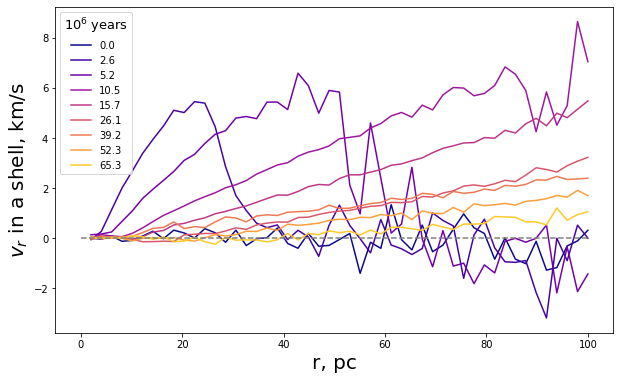

In [11]:
fig,ax = plt.subplots(figsize=(10,6))
color=iter(cm.plasma(np.linspace(0,1,10)))

for snap in v_in_shells.columns[1:]:
    c=next(color)
    ax.plot(v_in_shells['r'], v_in_shells[f'{snap}'], c=c, label=np.round(density_cs.iloc[int(snap),0], 1))
ax.plot([0,100], [0,0], ls='--', c='grey')
ax.set_xlabel('r, pc', fontsize=20)
ax.set_ylabel(r'$v_r$ in a shell, km/s', fontsize=20)
ax.legend(title=r'$10^6$ years', title_fontsize=13, fontsize=10)

Text(0, 0.5, '$v_r$ in a shell, km/s')

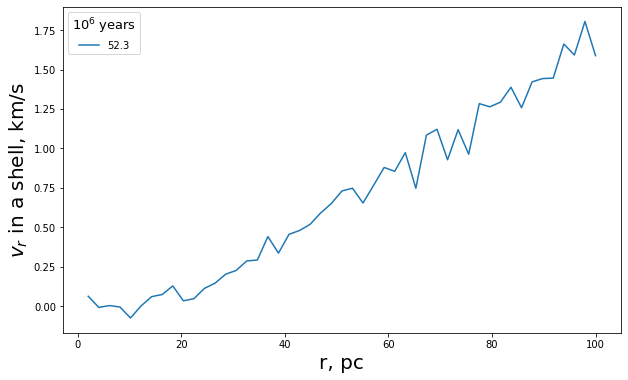

In [10]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(v_in_shells['r'], v_in_shells[f'{200}'], label=np.round(density_cs.iloc[int(200),0], 1))
ax.legend(title=r'$10^6$ years', title_fontsize=13, fontsize=10)
ax.set_xlabel('r, pc', fontsize=20)
ax.set_ylabel(r'$v_r$ in a shell, km/s', fontsize=20)